# Task 1.3: estimating the fractal dimension of objects in images

In [12]:
import numpy as np
import imageio.v3 as iio
import numpy.linalg as la
import scipy.ndimage as img
import matplotlib.pyplot as plt

### Binarization function
This function reads an image from its file path, reads it into a numpy array, and applies Gaussian filters and thresholding to create a binary image. It also automatically inverts the binary image if the background is dark, ensuring that the foreground is white (1).

This code was basically provided in the assignment description, However in the end we invert the black and white pixels automatically if needed so that the subject is always white.

In [57]:
def binarize(image_path):
    """
    Apply Gaussian filters and threshold to create binary image.
    Automatically inverts if needed so that foreground is black (1).
    """
    image = iio.imread(image_path, mode='L').astype(float)
    image_binary = np.abs(img.gaussian_filter(image, sigma=0.50) -
                          img.gaussian_filter(image, sigma=1.00))
    bin_img = img.binary_closing(np.where(image_binary < 0.1 * image_binary.max(), 0, 1))

    return bin_img


In [63]:
lightning_binary = binarize('resources/lightning.png')
iio.imwrite("results/3_lightning_binary.png", ((1-lightning_binary) * 255).astype(np.uint8))
# (1-binary) since iio.imwrite expects 0 to be black and 255 to be white, but our binary images have 0 as background and 1 as foreground.

In [64]:
tree_binary = binarize('resources/tree.png')
iio.imwrite("results/3_tree_binary.png", ((1-tree_binary) * 255).astype(np.uint8))

### Box counting function
Start with boxes of size 1/2 * image_width, then 1/4, 1/8, ..., down to 1/2^(L-2) where L = log2(image_width).

In [66]:
def box_count(image):
    """
    Compute box counts for multiple scales.
    Returns arrays of log(1/s) and log(n) for regression.
    """
    assert image.shape[0] == image.shape[1], "Image must be square"
    w = image.shape[0]
    L = int(np.log2(w))
    s_values = [1 / (2 ** l) for l in range(1, L - 1)]

    n_list = []
    for s in s_values:
        box_size = int(w * s)
        count = 0
        # Slide over the image with non-overlapping boxes
        for i in range(0, w, box_size):
            for j in range(0, w, box_size):
                if np.any(image[i:i + box_size, j:j + box_size]):
                    count += 1
        n_list.append(count)

    print(n_list)
    #  logs for regression
    log_inv_s = np.log(1 / np.array(s_values))
    log_n = np.log(np.array(n_list))
    return log_inv_s, log_n

In [67]:
lightning_log_inv_s, lightning_log_n = box_count(lightning_binary)
tree_log_inv_s, tree_log_n = box_count(tree_binary)

[4, 12, 32, 94, 254, 716, 2063]
[4, 16, 61, 218, 777, 2679, 8685]


## Estimate fractal dimension using least squares linear regression

In [68]:
def estimate_fractal_dimension(log_inv_s, log_n):
    A = np.vstack([log_inv_s, np.ones(len(log_inv_s))]).T
    D, b = la.lstsq(A, log_n, rcond=None)[0]
    return D, b

In [71]:
lightning_D, lightning_b = estimate_fractal_dimension(lightning_log_inv_s, lightning_log_n)
tree_D, tree_b = estimate_fractal_dimension(tree_log_inv_s, tree_log_n)

print("Estimated Fractal Dimensions:")
print(f"Lightning: D = {lightning_D:.3f}")
print(f"Tree: D = {tree_D:.3f}")

Estimated Fractal Dimensions:
Lightning: D = 1.493
Tree: D = 1.846


## Plotting results
For both images, log_inv_s is the same since both have the same dimensions. We can plot both datasets on the same graph for comparison.

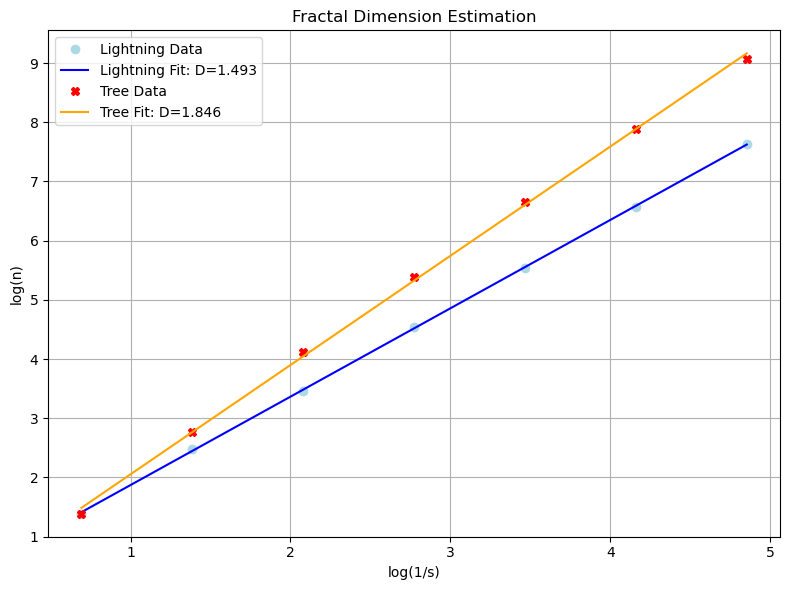

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(lightning_log_inv_s, lightning_log_n, 'o', label='Lightning Data', color='lightblue')
plt.plot(lightning_log_inv_s, lightning_D * lightning_log_inv_s + lightning_b, '-',
         label=f'Lightning Fit: D={lightning_D:.3f}', color='blue')
plt.plot(tree_log_inv_s, tree_log_n, 'X', label='Tree Data', color='red')
plt.plot(tree_log_inv_s, tree_D * tree_log_inv_s + tree_b, '-',
         label=f'Tree Fit: D={tree_D:.3f}', color='orange')
plt.xlabel('log(1/s)')
plt.ylabel('log(n)')
plt.title('Fractal Dimension Estimation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/3_fractal_dimension_plot.png")
plt.show()


### Final results
As we can see from the final plot, the estimated fractal dimension for the Tree picture is higher than the lightning, which was expected from the start since the tree picture has a more complex structure with more branches and details compared to the lightning.

### Challenges
1. Not being familiar with image processing libraries in Python initially made it challenging to implement the binarization function. However, by using AI (ChatGPT and Github Copilot) we were able to find the correct syntax and functions to achieve the desired results and validating them by visualizing the binary images.
2. The library used to capture the bitmap as a PNG file, uses the opposite numbers for foreground and background as the description of the task. We initially inverted the arrays to get the correct image output, which made the results wrong since we were counting the background boxes instead of the subject. However we caught this mistake when the final results were the opposite of what we expected and by printing the results of each step, we were able to identify and fix the issue.